# LSTM+CNN Next-Frame Prediction Architecture and Hyperparameter Analysis
This project attempts to discover the impact of various architectures and parameters on a Long-Short Term Memory (LSTM) Convolutional Neural Network (CNN) to analyze a series of images, considered frames of a video, and predict the next frame of the video. Each training and test example consists of a 20 frame video, where each frame is a 64 by 64 greyscale image. The model will use the first 10 frames to predict the 11th frame, the first 11 frames to predict the 12th, and so on until frames 11-20 are predicted. We can then visualize these latter 10 frames from both the example dataset and predicted set.

The different models differ in filter count, kernel size, batch size, layer count, epoch count, loss function, training dataset size, dropout layer inclusion, and activation function. Some of the models perform very similarly, but the best performing model arose after dropout layers were included, model #7.

In [ ]:
#importing packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import io
!pip install imageio
import imageio
from IPython.display import Image, display
!pip install ipywidgets
from ipywidgets import widgets, Layout, HBox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00


In [ ]:
#getting the dataset
mnist_fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)    

819200096/819200096 [==============================] - 13s 0us/step


## Setting Up Our Data

In [ ]:
dataset = np.load(mnist_fpath)

# Swap example count and frame count axes
dataset = np.swapaxes(dataset, 0, 1)
# Grab the first 1000 samples of the dataset
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split dataset into training and validation sets
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
#90% of the data goes to training with 10% going to validating
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
# this gives us the frames to train on x, and the truth values for those frames, y.
# We'll never need to predict the first frame, nor learn from the last frame
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


## Visualizing Our Data

Displaying frames for example 741.


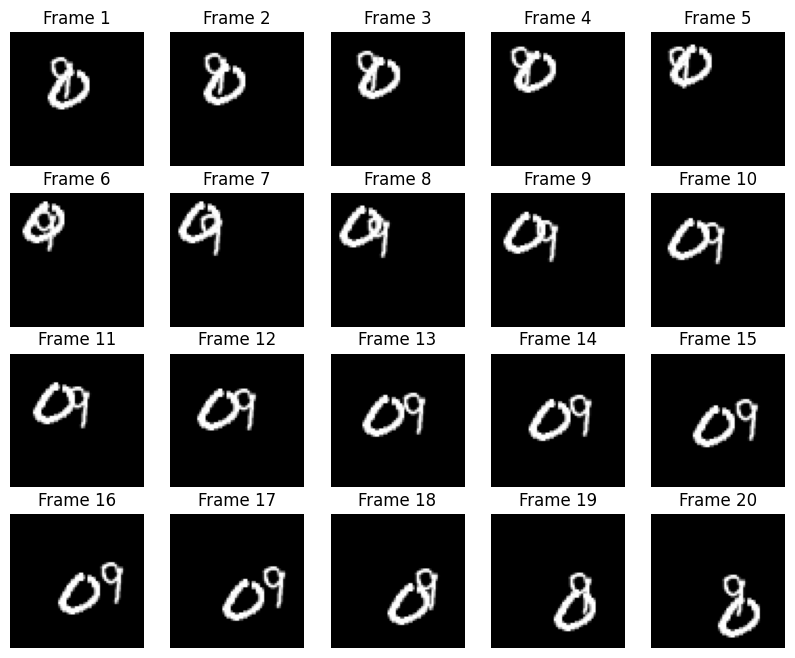

In [ ]:
#Visualization of one example
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(train_dataset[data_choice][idx], cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Callbacks
All of our models will use a learning rate scheduler with a patience of 3 and an early stopping restriction with a patience of 6.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 10

## Model 1
Our first, default, model consists of 3 2-Dimensional Convolution LSTM layers, with batch normalization between them. Each of these LSTM models has 64 filters, and the kernel size descends from (5, 5) to (1, 1). Finally we use a 3-Dimensional Convolution layer to convert from 2-D images to a 3-D video (the third dimension being time). This final layer uses a sigmoidal activation function, as we require outputs between 0 and 1, while the other layers use ReLU. It is compiled with the Adam optimizer and binary_crossentropy loss function. We train this function for 10 epochs with a batch size of 10.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
90/90 [==============================] - 139s 1s/step - loss: 0.1066 - val_loss: 0.2848 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 124s 1s/step - loss: 0.0308 - val_loss: 0.2001 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 124s 1s/step - loss: 0.0279 - val_loss: 0.1917 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 124s 1s/step - loss: 0.0270 - val_loss: 0.1690 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 124s 1s/step - loss: 0.0263 - val_loss: 0.1159 - lr: 0.0010
Epoch 6/10
90/90 [==============================] - 124s 1s/step - loss: 0.0259 - val_loss: 0.0668 - lr: 0.0010
Epoch 7/10
90/90 [==============================] - 124s 1s/step - loss: 0.0257 - val_loss: 0.0416 - lr: 0.0010
Epoch 8/10
90/90 [==============================] - 124s 1s/step - loss: 0.0255 - val_loss: 0.0293 - lr: 0.0010
Epoch 9/10
90/90 [==============================] - 124s 1s/step - loss: 0.0254 - val_loss: 0.0262 - lr:

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 57ms/step
 Truth	Prediction


This is a pretty good starting point, can be hard to tell what number is being represented though, and the edges are not very well defined. Some pixels are quite bright, which represents strong confidence in that pixel, which is something I found to become an issue later on.

# 2 - Additonal Layer
The difference in this model is that an additional convolutional LSTM layer has been included, along with its batch normalization. Everything about this layer is identical, and should add some complexity and trainable parameters to the model.

In [ ]:

inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
#additional layer
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 10
batch_size = 10

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
90/90 [==============================] - 180s 2s/step - loss: 0.2364 - val_loss: 0.2401 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 170s 2s/step - loss: 0.1798 - val_loss: 0.2609 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 170s 2s/step - loss: 0.1424 - val_loss: 0.2656 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 170s 2s/step - loss: 0.1084 - val_loss: 0.3184 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 170s 2s/step - loss: 0.0943 - val_loss: 1.0240 - lr: 1.0000e-04
Epoch 6/10
90/90 [==============================] - 174s 2s/step - loss: 0.0921 - val_loss: 1.7084 - lr: 1.0000e-04
Epoch 7/10
90/90 [==============================] - 174s 2s/step - loss: 0.0898 - val_loss: 1.8014 - lr: 1.0000e-04


In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 101ms/step
 Truth	Prediction


Increase in training time, decrease in number legibility and movement, this architecture will not be carried forward into the future models. Something caused extremely poor learning here, to the point where the model ended early. Perhaps the increase in complexity was too great.

# 3 - Scale Filters Instead
Here, instead of model 2's increase to complexity, we reduce complexity for the first two layers so that the model can abstract more simple patterns first, and then more complex patterns later. This should cut back on computation time without having too much of an impact on our output.

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    #filter # from 64 to 24
    filters=24,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    #filter # from 64 to 48
    filters=48,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 10
batch_size = 10

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
90/90 [==============================] - 82s 837ms/step - loss: 0.0985 - val_loss: 0.3085 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 73s 817ms/step - loss: 0.0310 - val_loss: 0.1980 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 74s 824ms/step - loss: 0.0284 - val_loss: 0.2203 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 74s 819ms/step - loss: 0.0274 - val_loss: 0.2162 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 74s 818ms/step - loss: 0.0267 - val_loss: 0.1438 - lr: 0.0010
Epoch 6/10
90/90 [==============================] - 74s 818ms/step - loss: 0.0263 - val_loss: 0.0676 - lr: 0.0010
Epoch 7/10
90/90 [==============================] - 74s 819ms/step - loss: 0.0260 - val_loss: 0.0386 - lr: 0.0010
Epoch 8/10
90/90 [==============================] - 74s 819ms/step - loss: 0.0259 - val_loss: 0.0281 - lr: 0.0010
Epoch 9/10
90/90 [==============================] - 74s 820ms/step - loss: 0.0255 - val_

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 50ms/step
 Truth	Prediction


Here we got rid of the grey flash, and the numbers are slightly less blurry than our first model. However, to a human, these videos are not as distinct as we would want, despite the low entropy value. The computation times were definitely faster than before, so we will be including these changes in later models.

# 4 - MSE Loss Function
Here we chose to test a different loss function, this time Mean Squared Error.

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=24,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=48,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
#Compile with mean_squared_error
model.compile(
    loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 10
batch_size = 10

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
90/90 [==============================] - 81s 829ms/step - loss: 0.0274 - val_loss: 0.0651 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 73s 816ms/step - loss: 0.0032 - val_loss: 0.0425 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 73s 816ms/step - loss: 0.0022 - val_loss: 0.0395 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 74s 818ms/step - loss: 0.0018 - val_loss: 0.0375 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 73s 817ms/step - loss: 0.0016 - val_loss: 0.0295 - lr: 0.0010
Epoch 6/10
90/90 [==============================] - 73s 816ms/step - loss: 0.0015 - val_loss: 0.0171 - lr: 0.0010
Epoch 7/10
90/90 [==============================] - 74s 817ms/step - loss: 0.0014 - val_loss: 0.0051 - lr: 0.0010
Epoch 8/10
90/90 [==============================] - 73s 816ms/step - loss: 0.0014 - val_loss: 0.0031 - lr: 0.0010
Epoch 9/10
90/90 [==============================] - 73s 817ms/step - loss: 0.0013 - val_

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 97ms/step
 Truth	Prediction


Way more blurry, way harder to see the numbers. A step back. Moving on.

# 5 - MAE Loss Function
Lets try another loss function, Mean Average Error.

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=24,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=48,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
#Compile with mean_absolute_error
model.compile(
    loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 10
batch_size = 10

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
90/90 [==============================] - 80s 829ms/step - loss: 0.0642 - val_loss: 0.0779 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 73s 814ms/step - loss: 0.0397 - val_loss: 0.0660 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 73s 816ms/step - loss: 0.0096 - val_loss: 0.0583 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 73s 816ms/step - loss: 0.0079 - val_loss: 0.0538 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 74s 818ms/step - loss: 0.0073 - val_loss: 0.0472 - lr: 0.0010
Epoch 6/10
90/90 [==============================] - 74s 817ms/step - loss: 0.0070 - val_loss: 0.0322 - lr: 0.0010
Epoch 7/10
90/90 [==============================] - 73s 817ms/step - loss: 0.0065 - val_loss: 0.0203 - lr: 0.0010
Epoch 8/10
90/90 [==============================] - 74s 818ms/step - loss: 0.0061 - val_loss: 0.0099 - lr: 0.0010
Epoch 9/10
90/90 [==============================] - 73s 817ms/step - loss: 0.0059 - val_

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 60ms/step
 Truth	Prediction


Something went wrong and I'm not sure what, but the model is not learning at all after the first epoch or two. Because of this the predictions are essentially non existant. Moving on.

# 6 - LeakyReLU
Lets swap from ReLU activations to LeakyReLU activations. These functions allow for some negative outputs, whereas ReLU outputs 0 if the activation input is not met.

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=24,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
)(inp)
x = layers.BatchNormalization()(x)
#LeakyReLU instead of ReLU
x = layers.LeakyReLU()(x)

x = layers.ConvLSTM2D(
    filters=48,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
)(x)
x = layers.BatchNormalization()(x)
#LeakyReLU instead of ReLU
x = layers.LeakyReLU()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
)(x)
#LeakyReLU instead of ReLU
x = layers.LeakyReLU()(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 10
batch_size = 10

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
90/90 [==============================] - 84s 852ms/step - loss: 0.1098 - val_loss: 0.2038 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 75s 833ms/step - loss: 0.0330 - val_loss: 0.3815 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 75s 834ms/step - loss: 0.0293 - val_loss: 0.4315 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 75s 834ms/step - loss: 0.0280 - val_loss: 0.3398 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 75s 833ms/step - loss: 0.0274 - val_loss: 0.1710 - lr: 1.0000e-04
Epoch 6/10
90/90 [==============================] - 75s 835ms/step - loss: 0.0273 - val_loss: 0.0754 - lr: 1.0000e-04
Epoch 7/10
90/90 [==============================] - 75s 835ms/step - loss: 0.0272 - val_loss: 0.0400 - lr: 1.0000e-04
Epoch 8/10
90/90 [==============================] - 75s 835ms/step - loss: 0.0272 - val_loss: 0.0298 - lr: 1.0000e-04
Epoch 9/10
90/90 [==============================] - 75s 835ms/step - los

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 54ms/step
 Truth	Prediction


A pretty great improvement! About equivalent to our previous binary crossentropy model in loss function value on our validate set, but much more legible anyway! This could be a good stopping point but I will continue testing other ideas.

# 7 - Dropout Layers
Here we add two dropout layers, one between the first two LSTM layers and the after the final LSTM layer. This should prevent overfitting

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=24,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
)(inp)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

#First Dropout Layer
x = layers.Dropout(.2)(x)

x = layers.ConvLSTM2D(
    filters=48,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
)(x)

#Second Dropout Layer
x = layers.Dropout(.2)(x)

x = layers.LeakyReLU()(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 10
batch_size = 10

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
90/90 [==============================] - 83s 857ms/step - loss: 0.1096 - val_loss: 0.2053 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - 76s 845ms/step - loss: 0.0347 - val_loss: 0.2024 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - 76s 846ms/step - loss: 0.0306 - val_loss: 0.2380 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - 76s 846ms/step - loss: 0.0290 - val_loss: 0.1859 - lr: 0.0010
Epoch 5/10
90/90 [==============================] - 76s 845ms/step - loss: 0.0283 - val_loss: 0.1200 - lr: 0.0010
Epoch 6/10
90/90 [==============================] - 76s 847ms/step - loss: 0.0277 - val_loss: 0.0579 - lr: 0.0010
Epoch 7/10
90/90 [==============================] - 76s 847ms/step - loss: 0.0274 - val_loss: 0.0360 - lr: 0.0010
Epoch 8/10
90/90 [==============================] - 79s 875ms/step - loss: 0.0271 - val_loss: 0.0294 - lr: 0.0010
Epoch 9/10
90/90 [==============================] - 76s 846ms/step - loss: 0.0268 - val_

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 64ms/step
 Truth	Prediction


Not much difference, a bit brighter of anything, although a slight increase in blur. This is still good practice though. Maybe a larger dropout rate coupled with more epochs would have a better impact.

# 8 - Batch Size 10 -> 15
Batch size can be an incredibly important hyper parameter. An increase in batch size generally reduces the models ability to generalize. However, they reduce generalization error, as each step has more information to go off of before the model learns. This could harm or help our model, depending on if we had too many or too few examples in our batches as it was. To go along with the increase to batch size, the epoch count was increased in case the batch size increase slowed down learning.

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=24,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
)(inp)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Dropout(.2)(x)

x = layers.ConvLSTM2D(
    filters=48,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
)(x)
x = layers.LeakyReLU()(x)

x = layers.Dropout(.2)(x)

x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)



model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 15
#Increased batch size and epoch size from 10 to 15
batch_size = 15

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/15
60/60 [==============================] - 95s 1s/step - loss: 0.1435 - val_loss: 0.2615 - lr: 0.0010
Epoch 2/15
60/60 [==============================] - 74s 1s/step - loss: 0.0413 - val_loss: 0.2026 - lr: 0.0010
Epoch 3/15
60/60 [==============================] - 71s 1s/step - loss: 0.0326 - val_loss: 0.2818 - lr: 0.0010
Epoch 4/15
60/60 [==============================] - 71s 1s/step - loss: 0.0310 - val_loss: 0.3303 - lr: 0.0010
Epoch 5/15
60/60 [==============================] - 71s 1s/step - loss: 0.0298 - val_loss: 0.2922 - lr: 0.0010
Epoch 6/15
60/60 [==============================] - 71s 1s/step - loss: 0.0292 - val_loss: 0.2511 - lr: 1.0000e-04
Epoch 7/15
60/60 [==============================] - 71s 1s/step - loss: 0.0291 - val_loss: 0.1742 - lr: 1.0000e-04
Epoch 8/15
60/60 [==============================] - 71s 1s/step - loss: 0.0290 - val_loss: 0.1126 - lr: 1.0000e-04
Epoch 9/15
60/60 [==============================] - 71s 1s/step - loss: 0.0289 - val_loss: 0.0684 - 

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 62ms/step
 Truth	Prediction


Without much change to our validation loss, this model seems to have more legible, if a bit darker, digits. This seems to be our best model yet, as we could remedy the darker shade of grey with some postprocessing techniques and it would look quite accurate. The increase in epoch count seems to have mattered, as it took a while for training to begin, seemingly because our learning rate was too high initially.

# 9 - Larger Dataset
Lets try incorporating a larger portion of our initial dataset. Up until now we have been working with a 9/1 training/validation split of 1000 examples. We will retain the ratio but increase the number of examples to 2500. This should slow learning significantly, but with a larger pool of data we should expect a better trained, more generalized, model.


In [ ]:
dataset = np.load(mnist_fpath)

dataset = np.swapaxes(dataset, 0, 1)
#Increased dataset size from 1000 to 2500
dataset = dataset[:2500, ...]
dataset = np.expand_dims(dataset, axis=-1)

indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (2250, 19, 64, 64, 1), (2250, 19, 64, 64, 1)
Validation Dataset Shapes: (250, 19, 64, 64, 1), (250, 19, 64, 64, 1)


In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=24,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
)(inp)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(.2)(x)
x = layers.ConvLSTM2D(
    filters=48,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
)(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
)(x)
x = layers.LeakyReLU()(x)

x = layers.Dropout(.2)(x)

x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

epochs = 15
batch_size = 15

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/15
150/150 [==============================] - 191s 1s/step - loss: 0.0856 - val_loss: 0.2692 - lr: 0.0010
Epoch 2/15
150/150 [==============================] - 180s 1s/step - loss: 0.0308 - val_loss: 0.3275 - lr: 0.0010
Epoch 3/15
150/150 [==============================] - 176s 1s/step - loss: 0.0286 - val_loss: 0.1493 - lr: 0.0010
Epoch 4/15
150/150 [==============================] - 176s 1s/step - loss: 0.0278 - val_loss: 0.0456 - lr: 0.0010
Epoch 5/15
150/150 [==============================] - 180s 1s/step - loss: 0.0273 - val_loss: 0.0279 - lr: 0.0010
Epoch 6/15
150/150 [==============================] - 176s 1s/step - loss: 0.0269 - val_loss: 0.0260 - lr: 0.0010
Epoch 7/15
150/150 [==============================] - 176s 1s/step - loss: 0.0266 - val_loss: 0.0257 - lr: 0.0010
Epoch 8/15
150/150 [==============================] - 180s 1s/step - loss: 0.0264 - val_loss: 0.0256 - lr: 0.0010
Epoch 9/15
150/150 [==============================] - 180s 1s/step - loss: 0.0262 - val_

In [ ]:
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        new_predictions[i] = predicted_frame

    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=10)
            predicted_videos.append(gif.getvalue())

print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

1/1 [==============================] - 0s 58ms/step
 Truth	Prediction


This seems like a step back, possibly because the variance in shading makes it more difficult for a human to read, while still getting closer to the real image, but maybe a lower learning rate was required with an increase epochs, as the learning rate scheduler never kicked in for this model with its increase in data and batch size. Still, it appears to be a great increase in training time for not much benefit.